## Advanced Lane Finding Project
The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## First, compute the camera calibration using chessboard images

## Compute Prespective 
Compute Distortion Matrix and then then the per-image application of prespective transform 

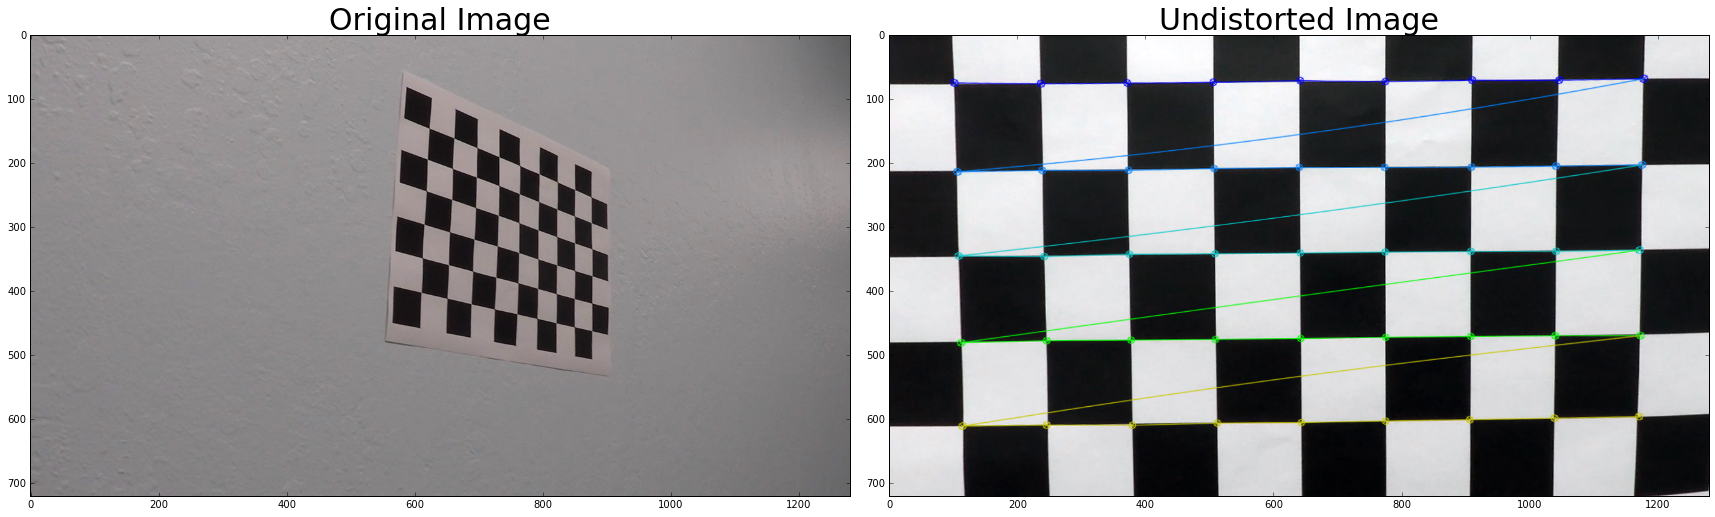

In [8]:
#Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points
nx = 9 # number of inside corners in x
ny = 5 # number of inside corners in y
objpoints = []
imgpoints = []

# Make a list of calibration images 
#use globe/blob function
images = glob.glob('camera_cal\calibration*.jpg')
objp = np.zeros((nx*ny,3),np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, add to point lists 
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)    
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist)
ax2.set_title('Undistorted Image', fontsize=30)

In [15]:
import math
#Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
import numpy as np
import cv2
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

def getprespective(img):
    width = img.shape[1]
    height = img.shape[0]
    
    #src = np.float32([[144,675],
    #                 [565,454],
    #                 [1180,675],
    #                 [716,454]])
    src = np.float32([[144,675],
                     [570,454],
                     [710,454],
                     [1180,675]])
    
    dst  = np.float32([[144,height],
                     [144,0 ],
                     [1180, 0],
                     [1180, height]])
    
    dbg = 0
    if (dbg==1):
        plt.figure()
        plt.imshow(img)
        pts = np.array(src, np.int32)
        pts = pts.reshape((-1,1,2))
        cv2.polylines(img,[pts],True,(0,255,255),4)        
    m1 = cv2.getPerspectiveTransform(src, dst)
    return(m1)

def getminv(img):
    width = img.shape[1]
    height = img.shape[0]

    src = np.float32([[144,675],
                     [570,454],
                     [710,454],
                     [1180,675]])
    
    dst  = np.float32([[144,height],
                     [144,0 ],
                     [1180, 0],
                     [1180, height]])
    minv = cv2.getPerspectiveTransform(dst,src)
    return minv

#Prespective Transform
def prespectiveimg(img, M):
    M = getprespective(img)
    warped = cv2.warpPerspective(img, M, img.shape, flags=cv2.INTER_LINEAR)
    return wraped

## Find Edges auxillary functions
Sobelx/y sobel magnitude & angle and S-thresholding 

In [16]:
def abs_sobel_thresh(simg, orient, thresh_min, thresh_max):
    if orient == 'x':
        sobelo = cv2.Sobel(simg, cv2.CV_64F, 1, 0)
    else:
        sobelo = cv2.Sobel(simg, cv2.CV_64F, 0, 1)
    abs_sobel = np.absolute(sobelo) # Takes the absolute value of the derivative or gradient
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel)) # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return sxbinary

def mag_thresh(simg, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(simg, cv2.CV_64F, 1, 0) #Take the gradient in x and y separately
    sobely = cv2.Sobel(simg, cv2.CV_64F, 0, 1)
    sobelm = np.sqrt(sobelx*sobelx +sobely*sobely) # 3) Calculate the magnitude 
    scaled_sobel = np.uint8(255*sobelm/np.max(sobelm)) # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1    
    return sxbinary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    sobely = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    sobeldir = np.arctan2(sobely, sobelx)
    dirbinary = np.zeros_like(sobelx)
    dirbinary[(sobeldir >= thresh[0]) & (sobeldir <= thresh[1])] = 1
    return dirbinary

def s_thresh(S, s_thresh_min,s_thresh_max):
    s_binary = np.zeros_like(S)
    s_binary[(S >= s_thresh_min) & (S <= s_thresh_max)] = 1
    return s_binary

## Find Edges function
uses a mixture of Sobelx/y sobel magnitude & angle and S-thresholding and returns a compund image

In [17]:
#color transform + sobel 
def lineit(edgeimg):
    ksize = 5
    gray = cv2.cvtColor(edgeimg, cv2.COLOR_RGB2GRAY)
    HLS = cv2.cvtColor(edgeimg, cv2.COLOR_RGB2HLS)
    S = HLS[:,:,2]
    sthresh = s_thresh(S, 110,255) 
    line_img = np.zeros((gray.shape[0], gray.shape[1], 3), dtype=np.uint8)
    gradx = abs_sobel_thresh(gray, 'x', 40, 255)
    grady = abs_sobel_thresh(gray, 'y', 50, 255)
    gradyS = abs_sobel_thresh(S, 'y', 30, 255)
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))    
    combined = np.zeros_like(sthresh)
    combinedSdir = np.zeros_like(sthresh)
    magdir = np.zeros_like(sthresh)
    magdir[((mag_binary == 1) & (dir_binary == 1))]=1
    combined[((gradyS == 1) & (grady == 1)) ] =1
    combinedSdir[((sthresh==1 ) & (dir_binary==1) )]=1
    color_binary = np.zeros_like(sthresh)
    color_binary[((combined == 1) | (combinedSdir==1) | (magdir == 1)) | (grady ==1) ] = 1 
    dbg = 0
    if (dbg==1):
        plt.figure()
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(gradx,cmap='gray')
        ax1.set_title('sobelx', fontsize=10)
        ax2.imshow(grady,cmap='gray')    
        ax2.set_title('sobely', fontsize=10)
        ax3.imshow(sthresh,cmap='gray')    
        ax3.set_title('S threshold', fontsize=10)
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))        
        ax1.imshow(mag_binary,cmap='gray')
        ax1.set_title('magnitude', fontsize=10)
        ax2.imshow(dir_binary,cmap='gray')
        ax2.set_title('direction', fontsize=10)
        ax3.imshow(magdir,cmap='gray')    
        ax3.set_title('mag-dir combined', fontsize=10)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(combinedSdir,cmap='gray')
        ax1.set_title('S channel with magnitude', fontsize=10)
        ax2.imshow(color_binary,cmap='gray')
        ax2.set_title('all combined', fontsize=10)
    return color_binary

In [18]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        self.frame = 0

# Find lane lines
using histogram for starting of lane

In [19]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
left = Line()
right = Line()

def findcenter(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return rightx_base, leftx_base

def getlanepoints(binary_warped,rightx_current, leftx_current):
    # Choose the number of sliding windows
     # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Set the width of the windows +/- margin
    margin =80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds
    

def fitlinespipe(binary_warped,img):
    global left,right
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    nonzero = binary_warped.nonzero() #check there is no problem here
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    rightx_current, leftx_current = findcenter(binary_warped)
    #print (rightx_current, leftx_current)
    
    left_lane_inds, right_lane_inds = getlanepoints(binary_warped,rightx_current, leftx_current)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    dbg = 0
    if (dbg==1):
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)

    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #Sanity
    dbg = 0
    if (dbg==0):
        if (left.frame ==0):
            left.detect = True
            right.detected = True  
            #radius of curvature of the line in some units
            left.radius_of_curvature = left_curverad
            right.radius_of_curvature = right_curverad
            left.line_base_pos = leftx_current
            right.line_base_pos = rightx_current 
            left.recent_xfitted = left_fitx
            right.recent_xfitted = right_fitx
            left.frame = left.frame + 1
        historyl=(np.absolute(1.0/left_curverad-1.0/left.radius_of_curvature)<0.001) 
        historyr=(np.absolute(1.0/left_curverad - 1.0/left.radius_of_curvature)<0.001)
        if ((rightx_current - leftx_current < 820) & (np.absolute(left_curverad-right_curverad)<1000) & historyl & historyr) :
            left.detect = True
            right.detected = True  
            #radius of curvature of the line in some units
            left.radius_of_curvature = left_curverad
            right.radius_of_curvature = right_curverad
            left.line_base_pos = leftx_current
            right.line_base_pos = rightx_current 
            left.recent_xfitted = left_fitx
            right.recent_xfitted = right_fitx
            left.frame = left.frame + 1
        else:
            left_fitx = left.recent_xfitted
            right_fitx = right.recent_xfitted   
            right_curverad = right.radius_of_curvature
            left_curverad = left.radius_of_curvature
            leftx_current = left.line_base_pos
            rightx_current = right.line_base_pos
            left.frame = left.frame + 1
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = getminv(binary_warped)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    s = 'Left radios ' + str(left_curverad)
    cv2.putText(result,s , (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255,4,2)
    s = 'Right radios ' + str(right_curverad)
    cv2.putText(result,s , (100,200), cv2.FONT_HERSHEY_SIMPLEX, 2, 255,4,2)
    pixeldeviationcm = 360.0 /(rightx_current - leftx_current)
    deviationcm = (1280-rightx_current-leftx_current)*pixeldeviationcm/2
    if ((640-leftx_current)>(rightx_current-640)):
        s = 'deviation to the right '+str(deviationcm)+ ' cm' 
    else:    
        s = 'deviation to the left '+str(deviationcm)+ ' cm' 
    cv2.putText(result,s , (100,300), cv2.FONT_HERSHEY_SIMPLEX, 2, 255,4,2)    
    return result, left_curverad, right_curverad

## Test function for single images

(2494.2740721508512, 1695.2708290062399)
(1182.5683937572323, 2008.6892226987302)


C:\Users\yossic\AppData\Local\Continuum\Anaconda2\lib\site-packages\matplotlib\pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


(2499.5339969071774, 1843.9813535177457)
(2072.0779384446219, 988.72786192919182)
(1274.4016883020083, 1829.1473739314092)
(23375.984630327359, 2916.772141876304)


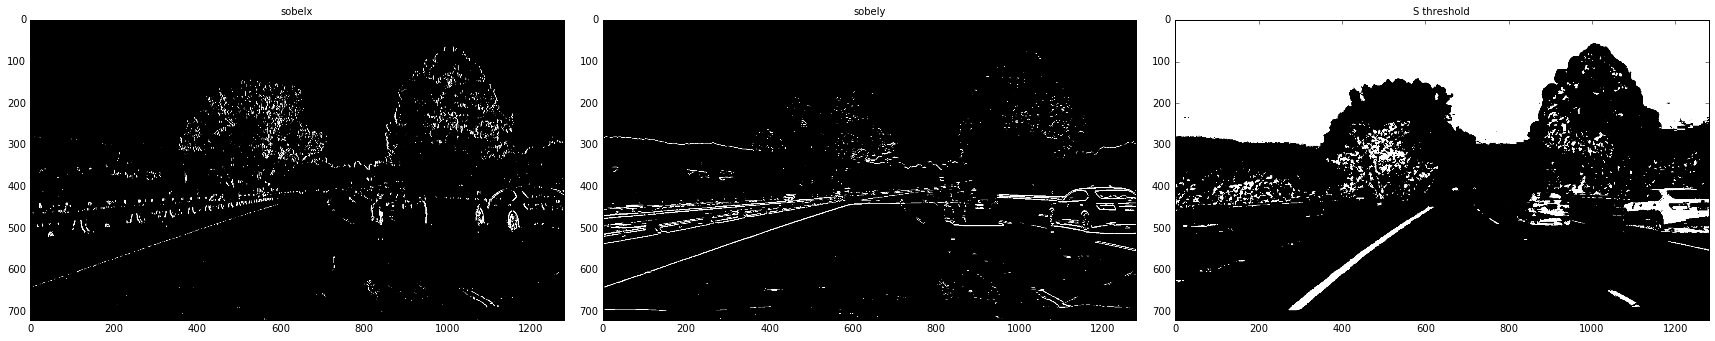

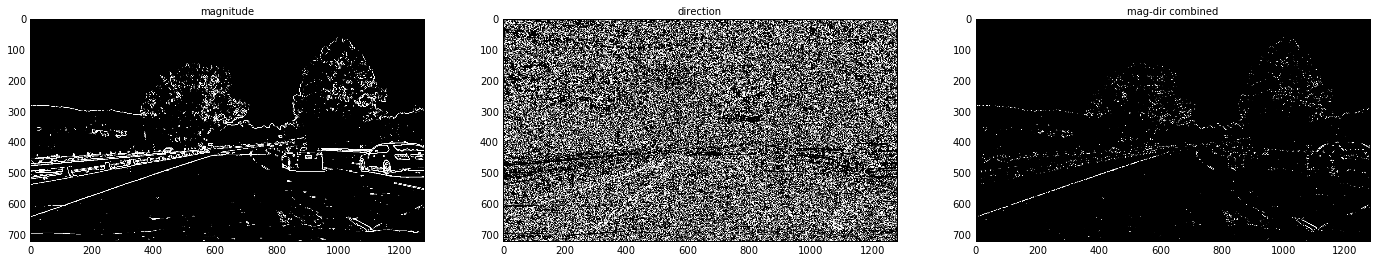

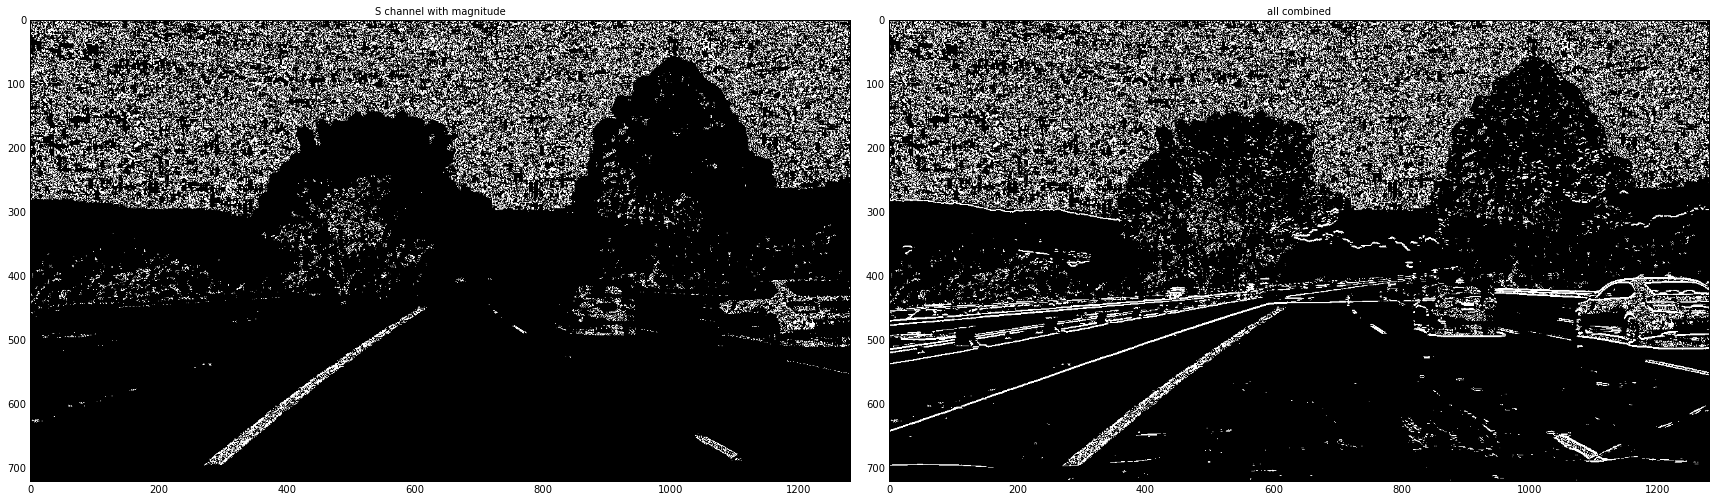

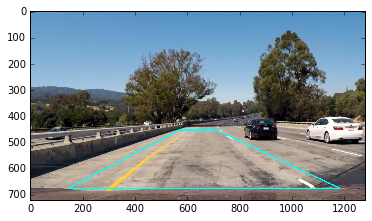

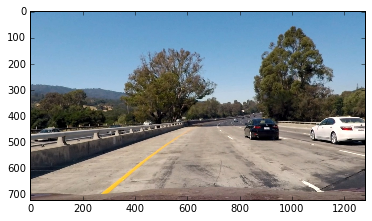

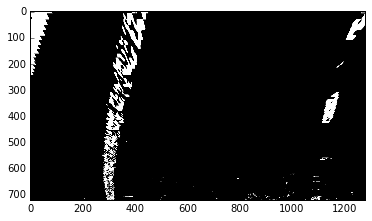

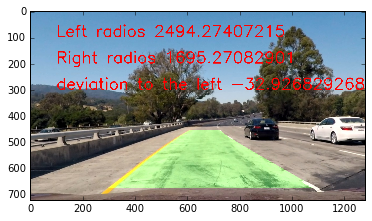

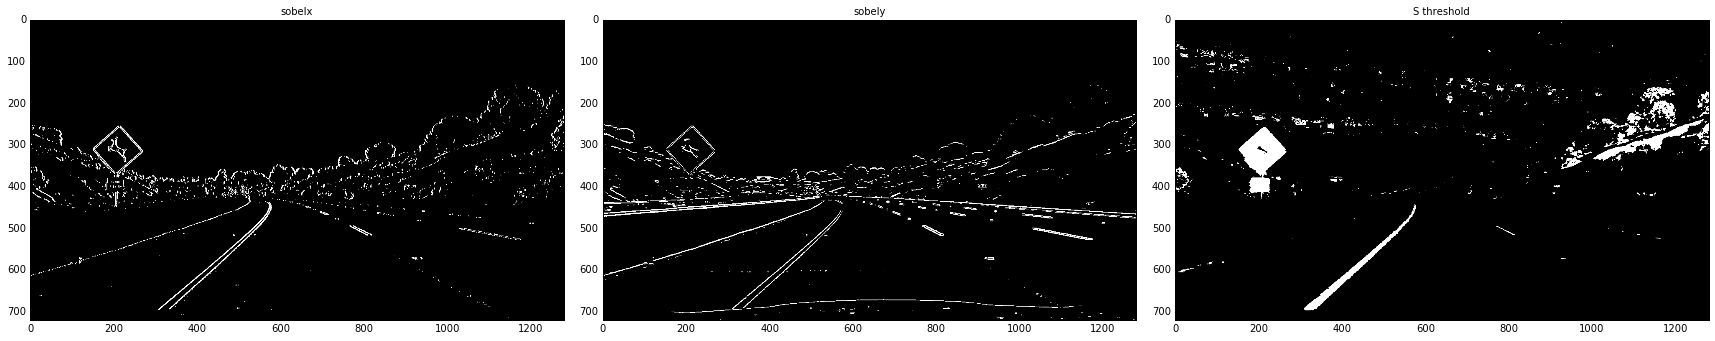

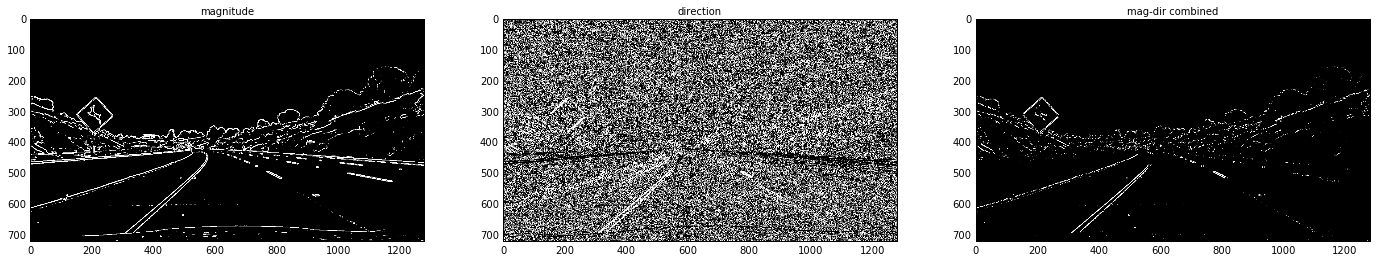

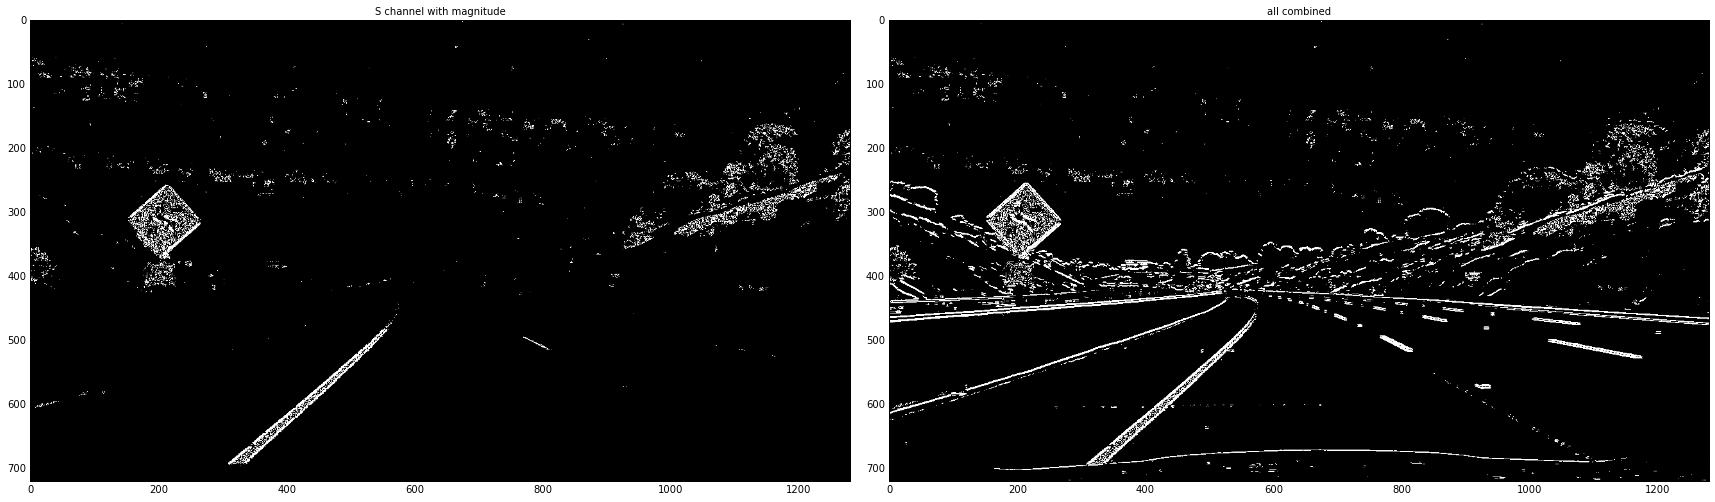

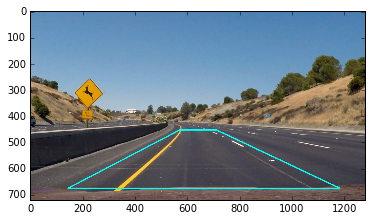

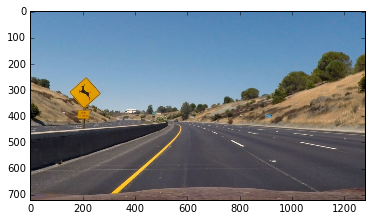

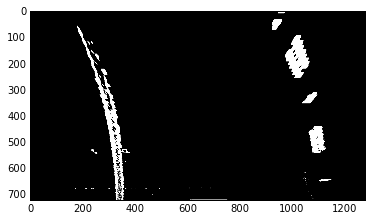

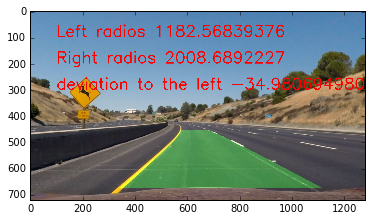

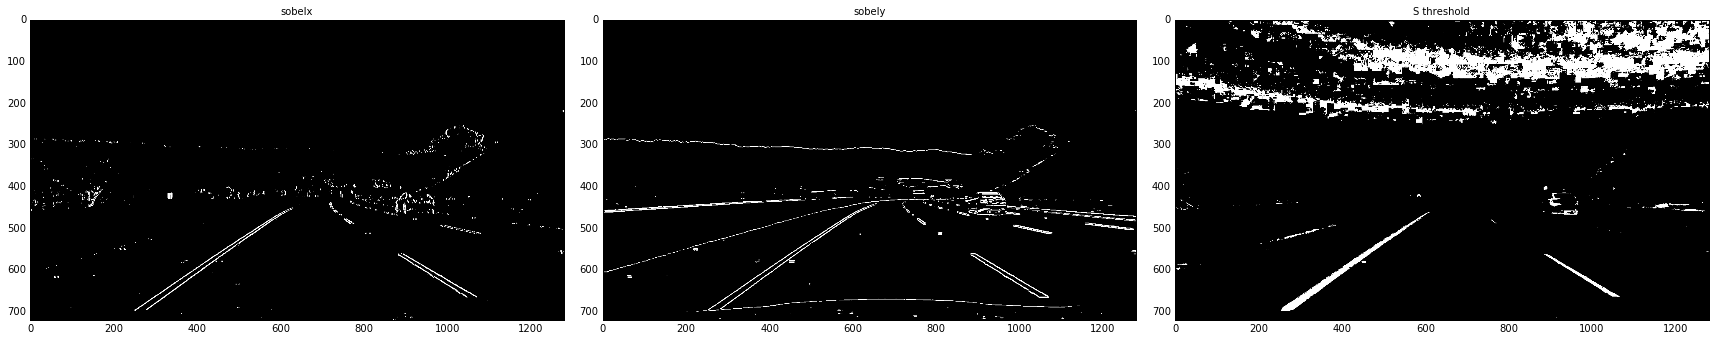

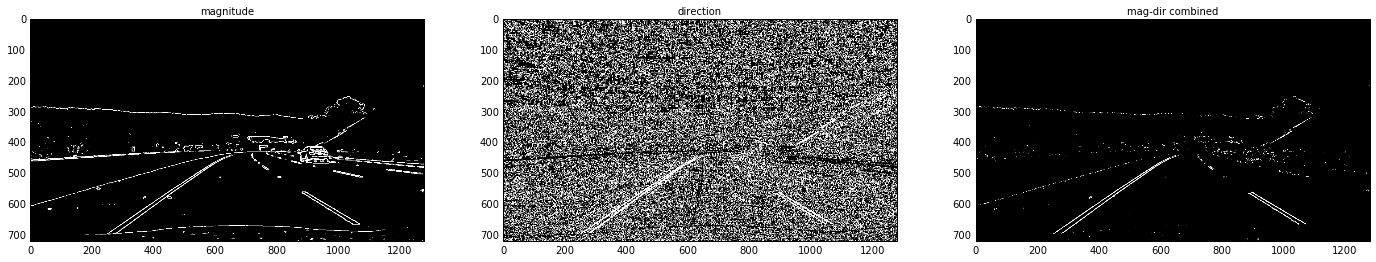

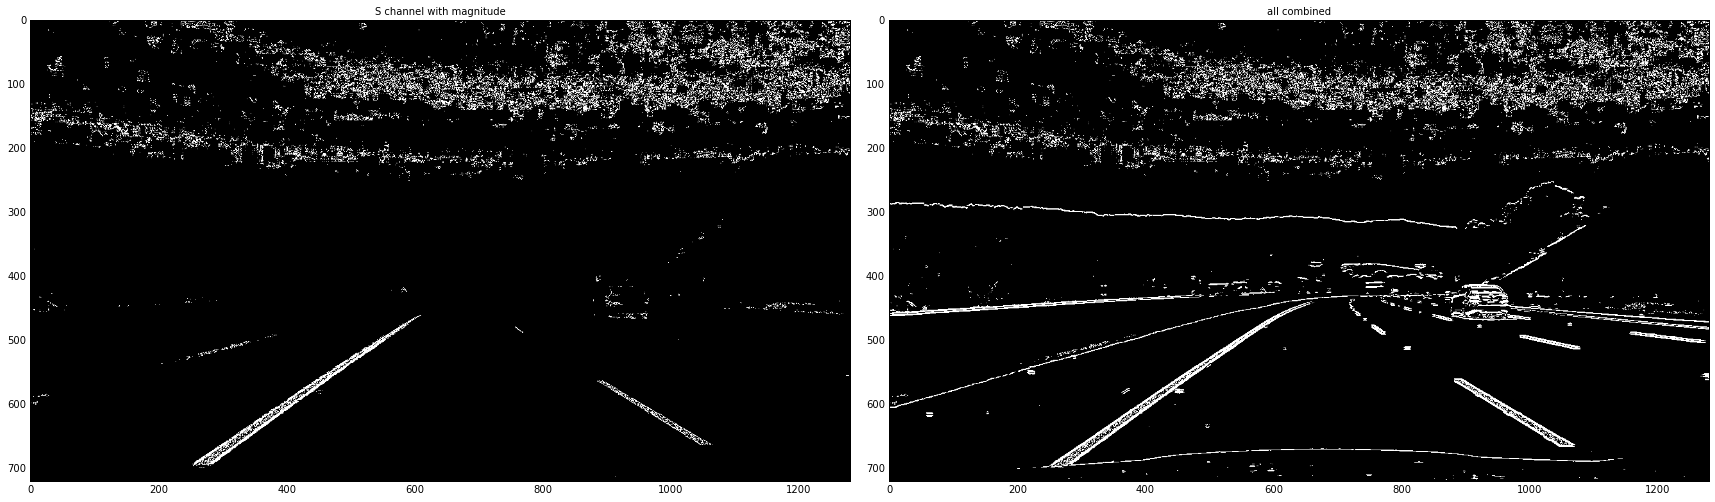

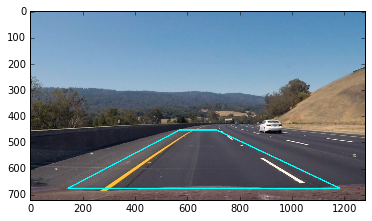

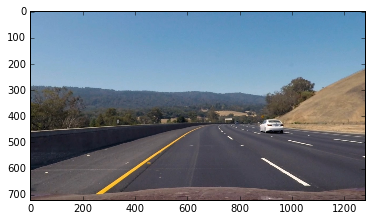

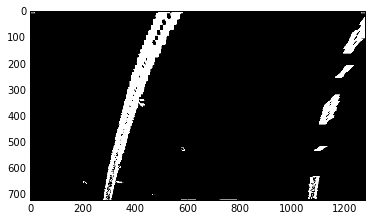

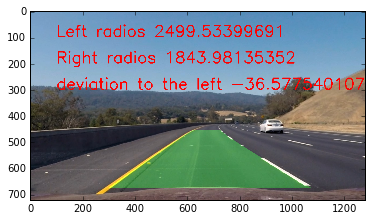

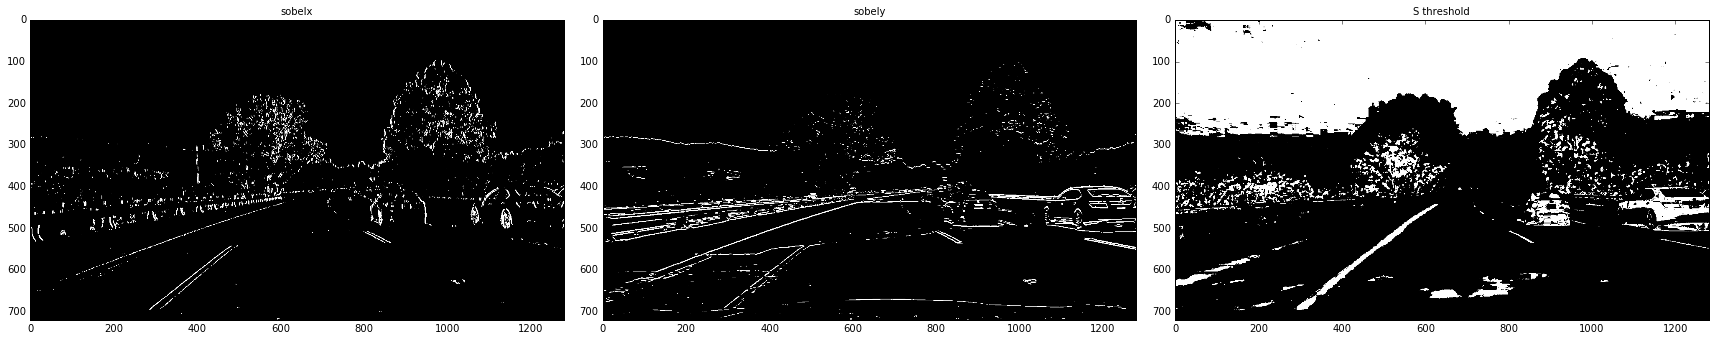

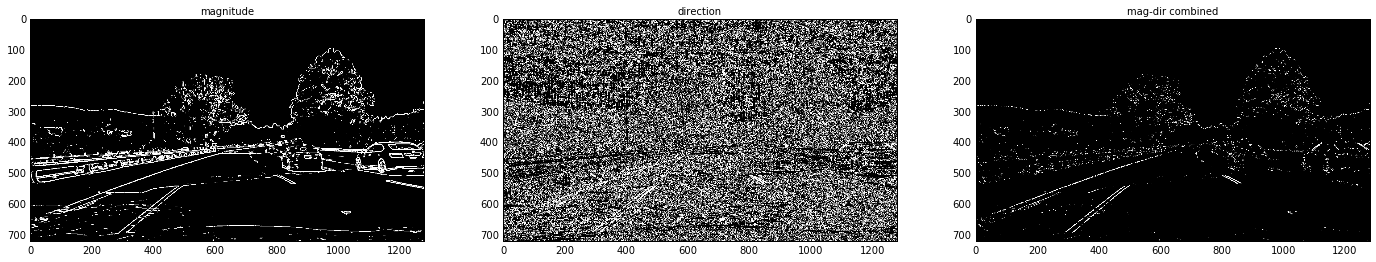

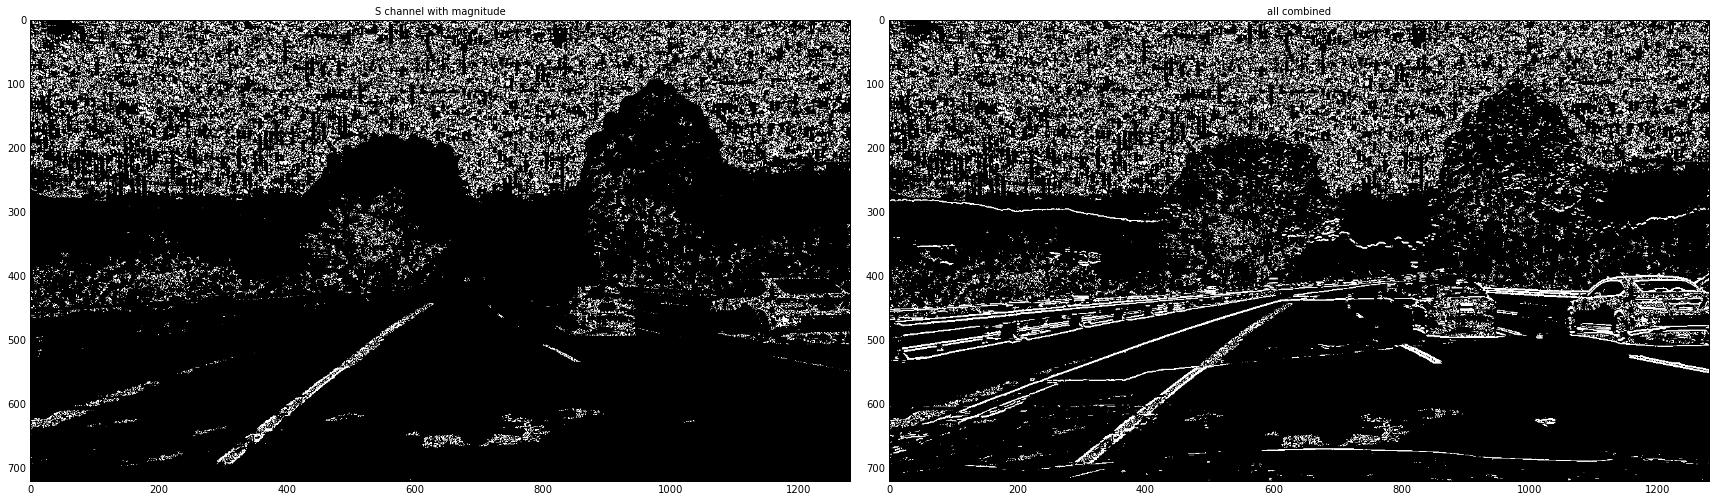

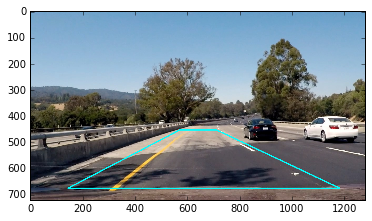

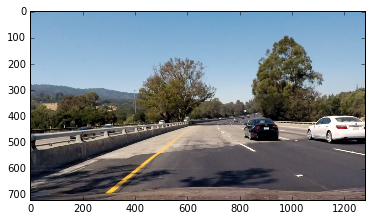

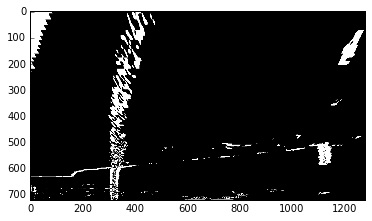

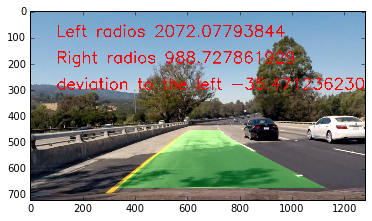

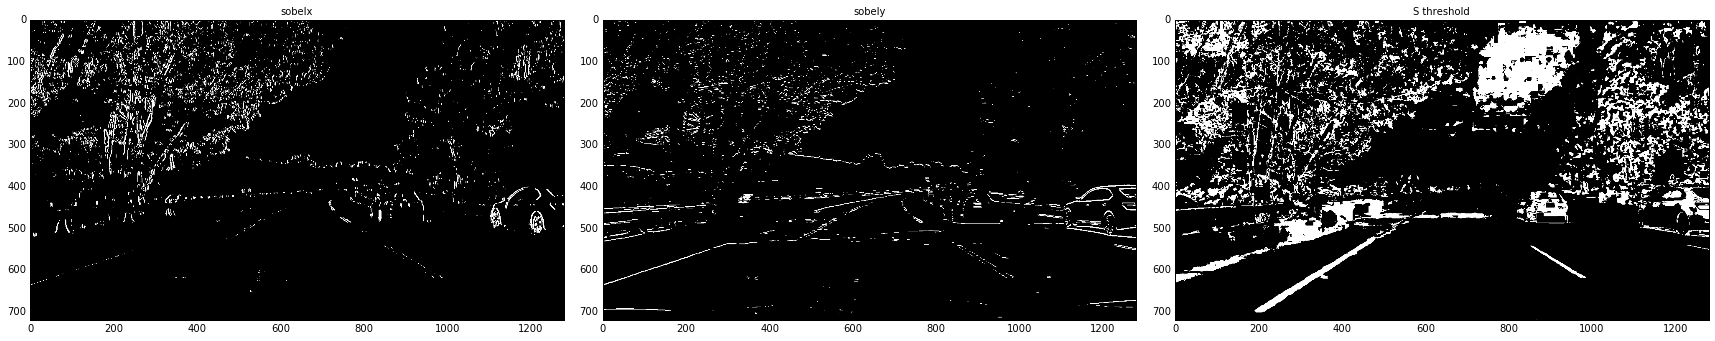

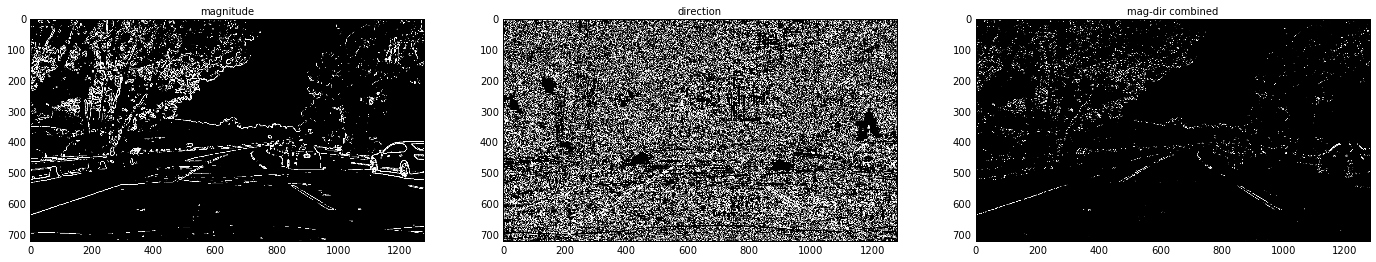

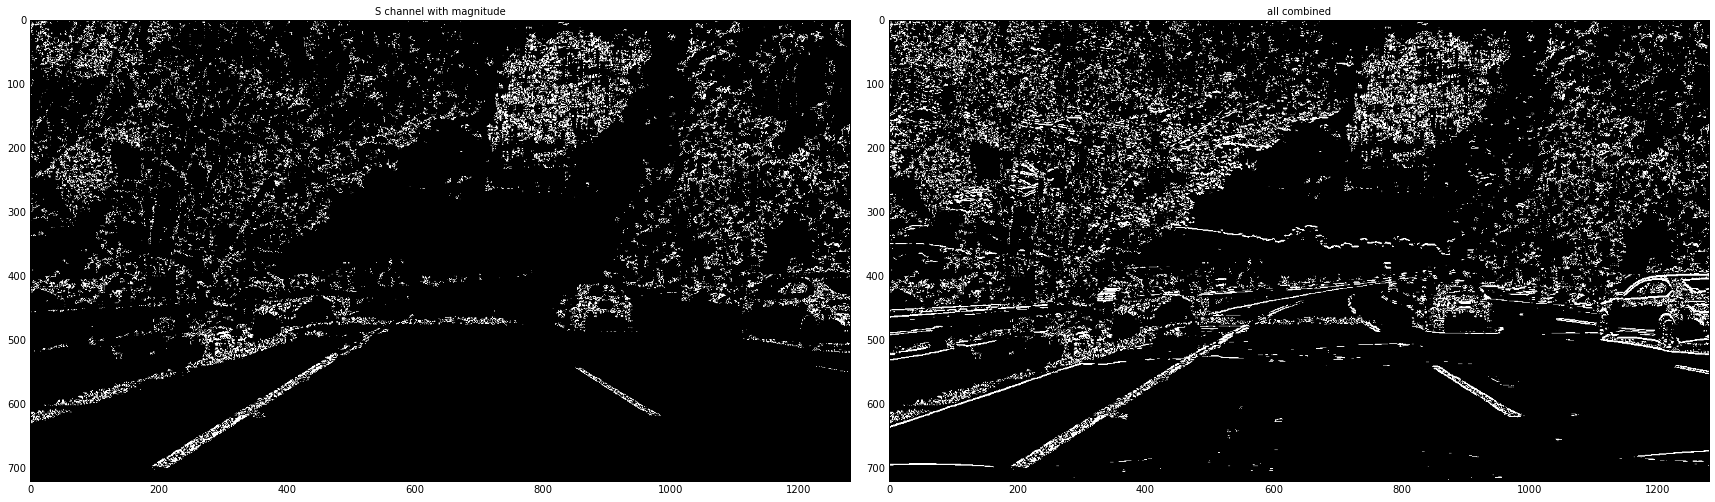

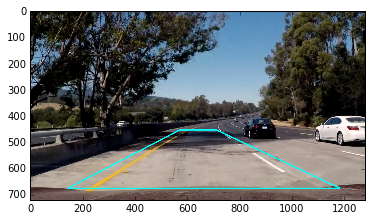

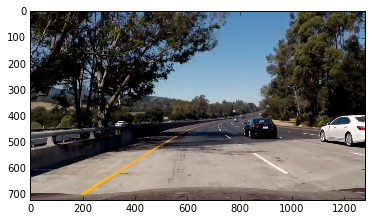

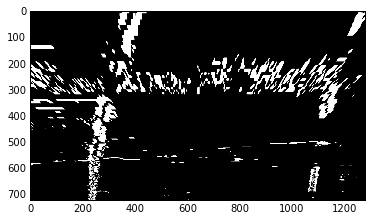

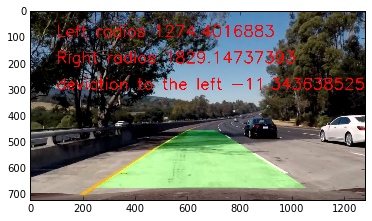

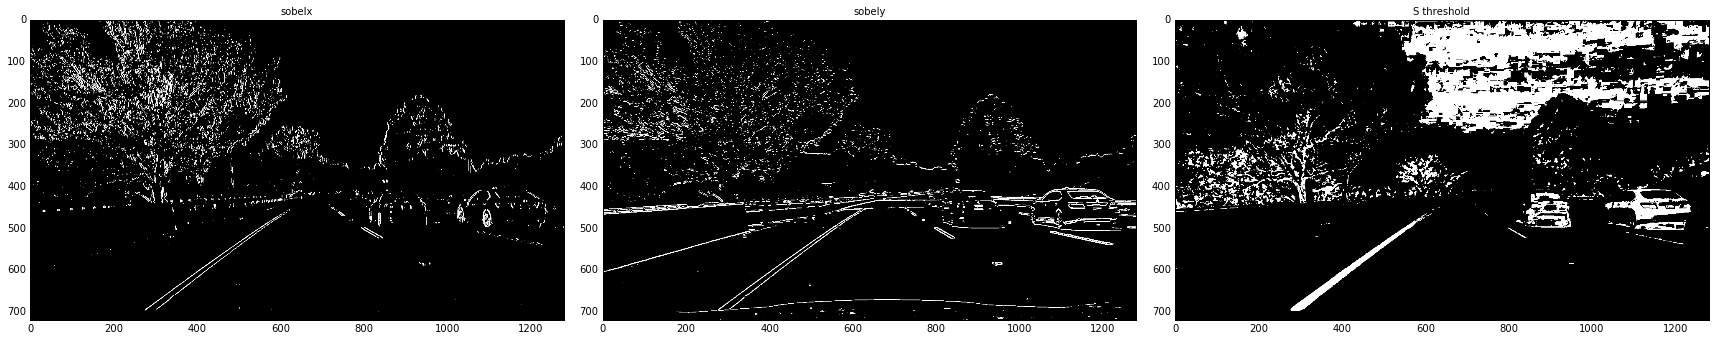

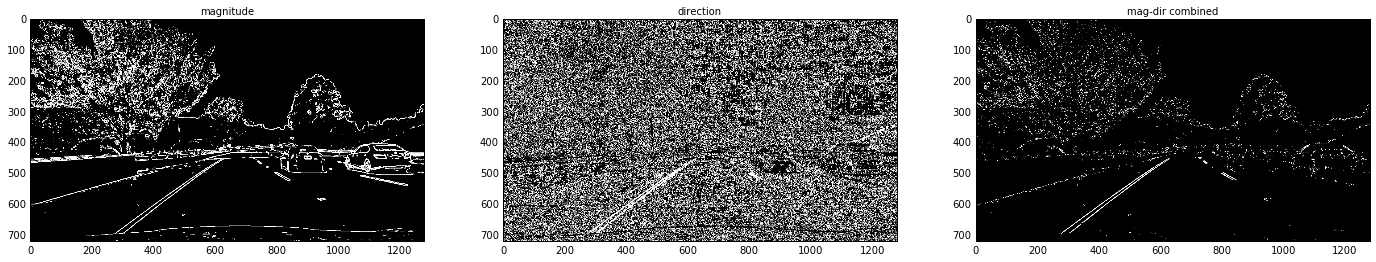

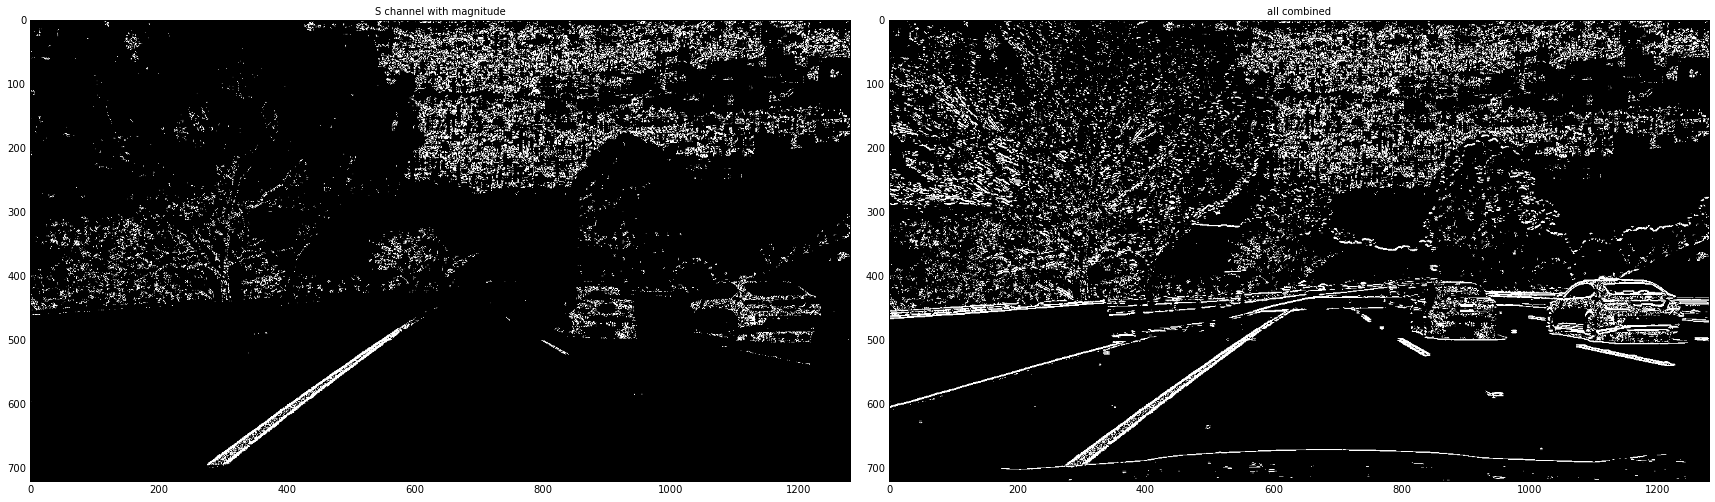

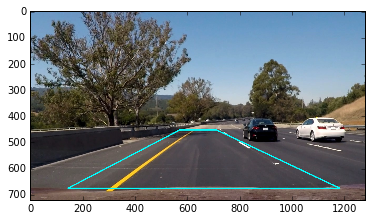

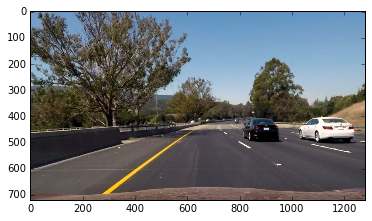

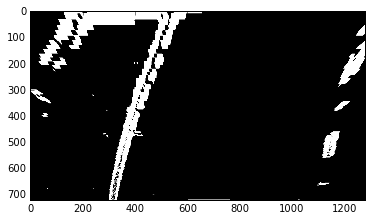

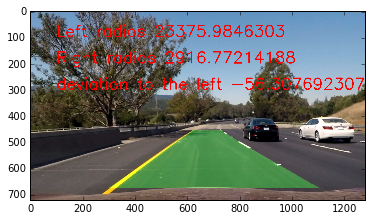

In [14]:
#Test 
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
%matplotlib inline

# Make a list of test images and use globe/blob function
imseries = glob.glob('test_images/test*.jpg')
for fname1 in imseries:
    img = mpimg.imread(fname1) #"test_images/test*.jpg")
    width = img.shape[1]
    height = img.shape[0]
    undi = cv2.undistort(img, mtx, dist, None, mtx) 
    edges = lineit(undi)
    m1 = getprespective(img)
    pres = cv2.warpPerspective(edges, m1, (width,height), flags=cv2.INTER_LINEAR)
    plt.figure()
    plt.imshow(undi) 
    plt.figure()
    plt.imshow(pres,cmap='gray' )    
    outimg, lc,rc = fitlinespipe(pres,undi)
    plt.figure()    
    plt.imshow(outimg)    
    print(lc,rc)    

In [20]:
#process image
frame = 1
line = Line
     
def process_image(img):
    global frame
    width = img.shape[1]
    height = img.shape[0]
    undi = cv2.undistort(img, mtx, dist, None, mtx) 
    edges = lineit(undi)
    m1 = getprespective(img)
    pres = cv2.warpPerspective(edges, m1, (width,height), flags=cv2.INTER_LINEAR)
    outimg, lc,rc = fitlinespipe(pres,undi) #fitlines(pres)
    frame = frame + 1
    return outimg

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
frame = 1
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")#("project_video.mp4")
white_clip = clip1.fl_image(process_image)
white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1260/1261 [07:50<00:00,  2.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 



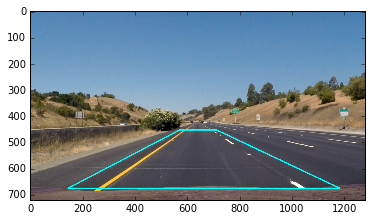

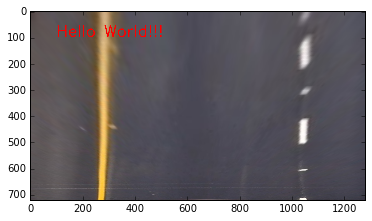

In [98]:
#Test perspective
img = mpimg.imread("test_images/straight_lines1.jpg")
width = img.shape[1]
height = img.shape[0]
undi = cv2.undistort(img, mtx, dist, None, mtx) 
m1 = getprespective(img)
pres = cv2.warpPerspective(undi, m1, (width,height), flags=cv2.INTER_LINEAR)
#cv2.putText(pres,"Hello World!!!", (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255,4,2)
plt.figure()
plt.imshow(pres)    
